In [5]:
import os
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

dbfile = os.path.expanduser("/Users/vishweshpv/Library/Application Support/Knowledge/knowledgeC.db")
conn = sqlite3.connect(dbfile)
query = """
SELECT
  ZOBJECT.ZVALUESTRING AS app,
  (ZOBJECT.ZENDDATE - ZOBJECT.ZSTARTDATE) AS usage_seconds,
  (ZOBJECT.ZSTARTDATE + 978307200) as start_ts,
  (ZOBJECT.ZENDDATE + 978307200) as end_ts,
  ZSOURCE.ZDEVICEID AS device_id
  FROM ZOBJECT
LEFT JOIN ZSOURCE ON ZOBJECT.ZSOURCE = ZSOURCE.Z_PK
WHERE ZSTREAMNAME = "/app/usage"
ORDER BY ZOBJECT.ZSTARTDATE DESC
"""
df = pd.read_sql_query(query, conn)
conn.close()

# convert timestamps to datetime
df['start'] = pd.to_datetime(df['start_ts'], unit='s')
df['end'] = pd.to_datetime(df['end_ts'], unit='s')
df['duration_min'] = df['usage_seconds'] / 60.0

# feature engineering
df['hour'] = df['start'].dt.hour
df['dayofweek'] = df['start'].dt.dayofweek
df['date'] = df['start'].dt.date

# aggregate: total usage by app by date
agg = df.groupby(['date','app']).agg({
    'duration_min':'sum',
}).reset_index()

agg


,date,app,duration_min
0,2025-10-06,com.apple.AddressBook,0.033333
1,2025-10-06,com.apple.AppStore,2.250000
2,2025-10-06,com.apple.Passwords,0.316667
3,2025-10-06,com.apple.Photos,0.083333
4,2025-10-06,com.apple.Preview,2.716667
...,...,...,...
513,2025-11-01,com.apple.systempreferences,0.716667
514,2025-11-01,com.google.Chrome,12.100000
515,2025-11-01,com.google.Chrome.app.agimnkijcaahngcdmfeangak...,33.033333
516,2025-11-01,com.microsoft.VSCode,116.833333


In [6]:
agg.describe()

,duration_min
count,518.000000
mean,15.328861
std,33.390748
min,0.000000
25%,0.250000
50%,1.600000
75%,12.375000
max,304.450000


In [8]:
agg.dtypes

date             object
app              object
duration_min    float64
dtype: object

In [10]:
agg['date']=pd.to_datetime(agg.date)

In [11]:
agg.dtypes

date            datetime64[ns]
app                     object
duration_min           float64
dtype: object

In [12]:
agg.isnull().sum()

date            0
app             0
duration_min    0
dtype: int64

In [21]:
def change_names(app):
    names=[]
    if 'google' in app:
        names.append('google')
    elif 'apple' in app:
        names.append('apple')
    elif 'python' or 'anaconda' or 'rstudio' or 'sql' or 'dbeaver' or 'mongodb' or 'jdbc' or 'java'  in app:
        names.append('Coding')
    elif 'whatsapp' in app:
        names.append('whatsapp')
    elif 'microsoft' in app:
        names.append('microsoft')
    elif 'claude' or 'openai' in app:
        names.append('AI')
    elif 'spotify' in app:
        names.append('spotify')
    else:
        names.append('others')

agg['app']=agg.apply(change_names(agg['app']))

agg

TypeError: Must provide 'func' or tuples of '(column, aggfunc).

<BarContainer object of 518 artists>

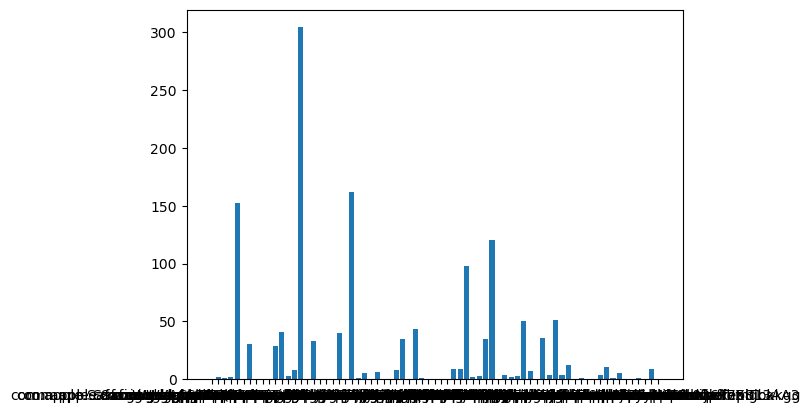

In [14]:
import matplotlib.pyplot as plt

plt.bar(agg.app,agg.duration_min)

